# Making a connection to MySQL Database to execute queries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

# Connect to the MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Root@253001',
    database='ecommerce'
)
cur = db.cursor()

# Basic Queries
# 1. List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = """select count(order_id) from ecommerce.orders where year(order_purchase_timestamp) = 2017;"""
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [5]:
query = """select Upper(p.product_category), round(sum(py.payment_value), 2) as Sales
FROM ecommerce.products p
inner join ecommerce.order_item o on o.product_id = p.product_id
inner join ecommerce.payments py on py.order_id = o.order_id
group by p.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """SELECT (sum(case when payment_installments >=1 then 1 else 0 end)/count(*))*100
FROM ecommerce.payments;"""
cur.execute(query)
data = cur.fetchall()
"Percentage of orders that were paid in installments are", data[0][0]

('Percentage of orders that were paid in installments are', Decimal('99.9981'))

# 5. Count the number of customers from each state. 

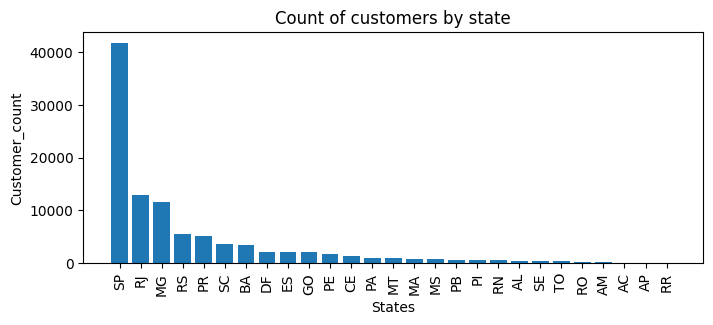

In [7]:
query = """SELECT customer_state, Count(customer_id) as Count FROM ecommerce.customers group by customer_state order by customer_state;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["State","Customer_Count"])
df = df.sort_values(by = "Customer_Count", ascending=False)

plt.figure(figsize = (8,3))
plt.bar(df["State"], df["Customer_Count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of customers by state")
plt.show()

# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

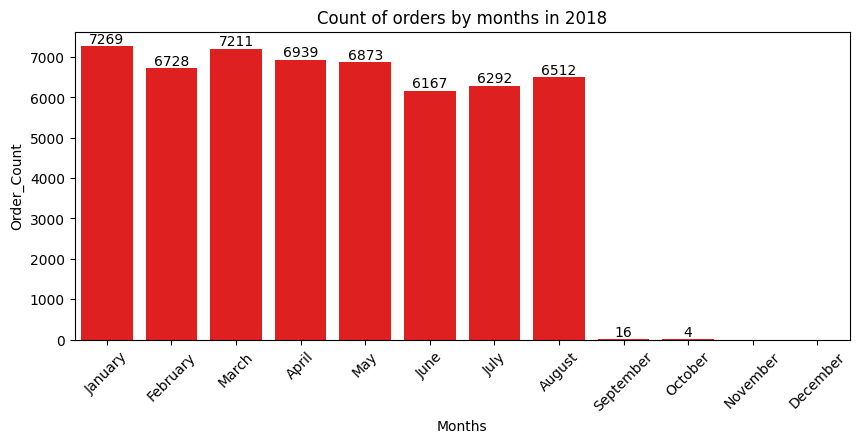

In [8]:
query = """SELECT monthname(order_purchase_timestamp) as Month, count(order_id) as Sales_Count FROM ecommerce.orders
where year(order_purchase_timestamp) = 2018 group by Month;"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns=["Months","Order_Count"])
o=["January","February","March","April","May","June","July","August","September","October", "November","December"]

plt.figure(figsize=(10,4))
ax = sns.barplot(x=df["Months"], y=df["Order_Count"], data=df, order=o, color="Red")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months in 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [9]:
query = """with count_per_order as(
SELECT o.order_id, o.customer_id, count(oi.order_id) as count
FROM ecommerce.orders o
inner join ecommerce.order_item oi on o.order_id = oi.order_id
group by o.order_id, o.customer_id)

select c.customer_city, round(avg(cp.count),2) as average
from ecommerce.customers c
inner join count_per_order cp on c.customer_id = cp.customer_id
group by c.customer_city order by average desc;"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns=["customer_city", "Average_orders"])
df.head()

,customer_city,Average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# 3. Calculate the percentage of total revenue contributed by each product category.

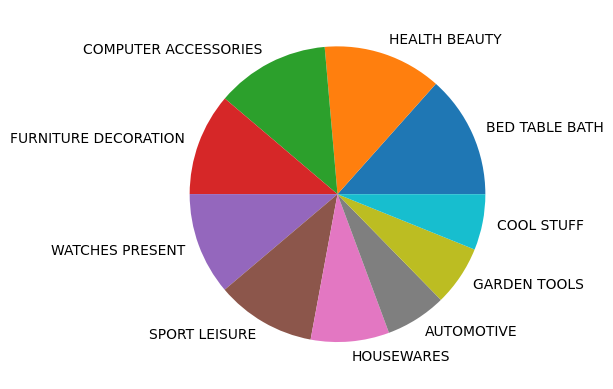

In [85]:
query = """select Upper(p.product_category) as Category, 
round((sum(py.payment_value)/(Select sum(payment_value) from ecommerce.payments)*100), 2) as Sales_Percentage
FROM ecommerce.products p
inner join ecommerce.order_item o on o.product_id = p.product_id inner join ecommerce.payments py on py.order_id = o.order_id
group by p.product_category order by Sales_Percentage desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category","Percentage_Distribution"])
df=df.head(10)
df

plt.pie(df["Percentage_Distribution"], labels=df["Category"])
plt.show()   #Showing only 10 values

# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """select p.product_category, count(oi.Product_id) as Count, round(avg(oi.Price) , 2) as Price
from ecommerce.products p
inner join ecommerce.order_item oi on oi.product_id = p.product_id
group by p.product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category","Order_Count","Price"])

arr1=df["Order_Count"]
arr2=df["Price"]
a = np.corrcoef([arr1, arr2])   #result is neutral
"correlation between product price and the number of times a product has been purchased is", a[0][1] 

('correlation between product price and the number of times a product has been purchased is',
 -0.10631514167157562)

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

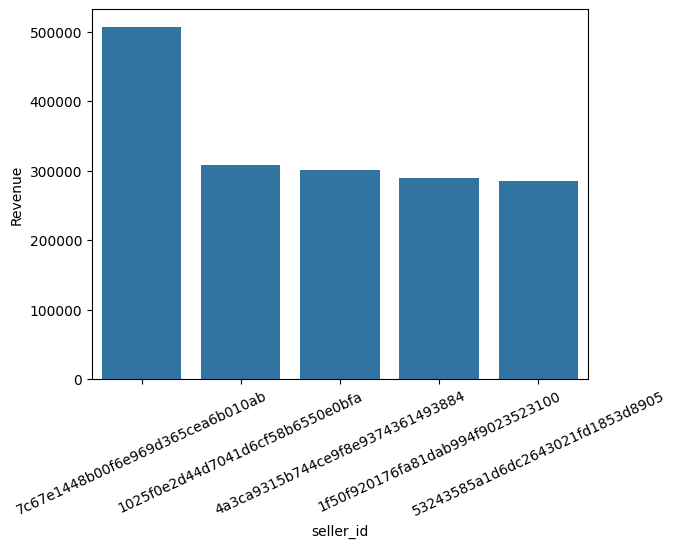

In [11]:
query = """select *, dense_rank() over(order by revenue desc) as Rankk from (
select oi.seller_id, sum(p.payment_value) as revenue
from ecommerce.sellers s 
inner join ecommerce.order_item oi on oi.seller_id = s.seller_id
inner join ecommerce.payments p on p.order_id = oi.order_id
group by oi.seller_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["seller_id","Revenue","Rank"])
df = df.head()

sns.barplot(x=df["seller_id"], y=df["Revenue"], data=df)
plt.xticks(rotation=25)
plt.show()


# Advanced Queries
# 1. Calculate the moving average of order values for each customer over their order history.

In [16]:
query = """select o.customer_id, o.order_purchase_timestamp, p.payment_value, avg(p.payment_value) 
over(partition by o.customer_id order by o.order_purchase_timestamp 
rows between 2 preceding and current row) as moving_avg
from ecommerce.orders o
inner join ecommerce.payments p on p.order_id = o.order_id"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer_id","Order_Purchase_Timestamp","Price","Moving_Average"])
df

,Customer_id,Order_Purchase_Timestamp,Price,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [20]:
query = """select years, months, payment, sum(payment) over(order by years, months) from (
select year(o.order_purchase_timestamp) as years, month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value), 2) as payment
from ecommerce.orders o inner join ecommerce.payments p on o.order_id = p.order_id
group by years, months order by years, months) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Months","Payment","Cummulative_Sum"])
df

,Years,Months,Payment,Cummulative_Sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 3. Calculate the year-over-year growth rate of total sales.

In [22]:
query = """with cte as(
select year(o.order_purchase_timestamp) as years, sum(p.payment_value) as payment
from ecommerce.orders o inner join ecommerce.payments p on o.order_id = p.order_id
group by years order by years)
select *, round(((cte.payment - lag(cte.payment, 1) over(order by years))/
(lag(cte.payment, 1) over(order by years)))*100,2) as YoY_Per_Growth from cte"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Sales","YoY_Percentage_Growth"])
df

,Years,Sales,YoY_Percentage_Growth
0,2016,5.936234e+04,NaN
1,2017,7.249747e+06,12112.7
2,2018,8.699763e+06,20.0


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [25]:
query = """with a as (select c.customer_id, min(o.order_purchase_timestamp) as First_Order
from ecommerce.customers c 
inner join ecommerce.orders o on o.customer_id = c.customer_id
group by c.customer_id), b as(
select a.customer_id, count(distinct o.order_purchase_timestamp) as Next_Order
from a inner join ecommerce.orders o on o.customer_id = a.customer_id
and o.order_purchase_timestamp > a.first_order and
o.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) as Retention_Rate
from a left join b on a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()
data    #None of the customer found 

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.


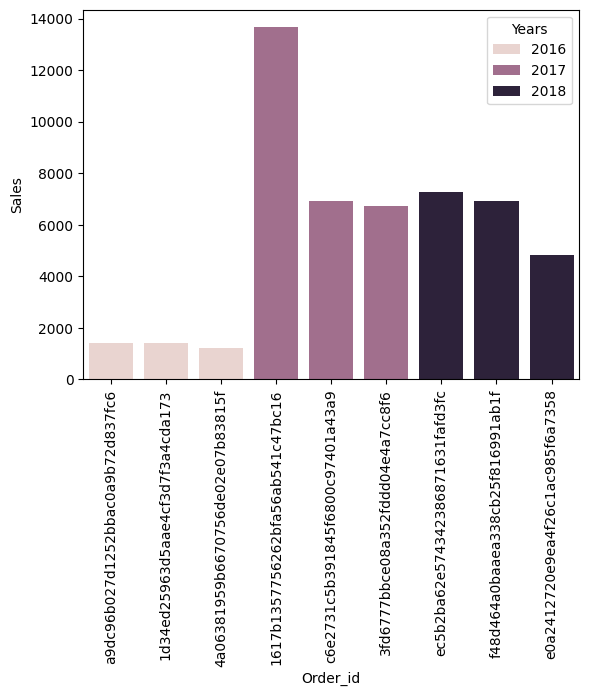

In [32]:
query = """select Year, customer_id, round(payment, 2) as Sales, d_rank from
(select year(o.order_purchase_timestamp) as Year, o.customer_id, sum(p.payment_value) as payment, 
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) as d_rank 
from ecommerce.orders o inner join ecommerce.payments p on o.order_id = p.order_id
group by Year, o.order_id, o.customer_id) as a where d_rank <=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Order_id","Sales","Rank"])

sns.barplot(x="Order_id", y="Sales", data=df, hue="Years")
plt.xticks(rotation=90)
plt.show()